In [1]:
from tdc.multi_pred import DTI
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from transformers import BertTokenizer, BertModel
import torch

In [2]:
from tdc.multi_pred import DTI
data = DTI(name = 'KIBA')
split = data.get_split()

Found local copy...
Loading...
Done!


In [3]:
split.keys()

dict_keys(['train', 'valid', 'test'])

In [4]:
train_data_torch = torch.load('train_data_kiba.pt')
valid_data_torch = torch.load('valid_data_kiba.pt')
test_data_torch = torch.load('test_data_kiba.pt')

In [5]:
all_data = pd.concat([train_data_torch, valid_data_torch, test_data_torch])
all_data.head()

,Drug_ID,Drug,Target_ID,Target,Y,Affinity,Drug_Features,Target_Features
0,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,O14920,MSWSPSLTTQTCGAWEMKERLGTGGFGNVIRWHNQETGEQIAIKQC...,11.1,-1.045323,"[0.6770583, 0.41921705, 0.48858222, -0.7087556...","[-0.055035256, -0.2370438, 0.12921442, 0.03794..."
1,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,P04626,MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...,11.1,-1.045323,"[0.6770583, 0.41921705, 0.48858222, -0.7087556...","[0.0592521, -0.0788976, 0.0388172, 0.008689172..."
2,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,P06239,MGCGCSSHPEDDWMENIDVCENCHYPIVPLDGKGTLLIRNGSEVRD...,11.1,-1.045323,"[0.6770583, 0.41921705, 0.48858222, -0.7087556...","[0.062962525, -0.16676156, 0.17776552, 0.06423..."
3,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,P15056,MAALSGGGGGGAEPGQALFNGDMEPEAGAGAGAAASSAADPAIPEE...,11.1,-1.045323,"[0.6770583, 0.41921705, 0.48858222, -0.7087556...","[0.016484981, -0.18309374, 0.066730805, 0.0375..."
4,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,P24941,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,11.1,-1.045323,"[0.6770583, 0.41921705, 0.48858222, -0.7087556...","[-0.0106953485, -0.27949733, 0.21388407, 0.137..."


In [6]:
from sklearn.model_selection import train_test_split

# Separate the dataset by unique proteins and drugs
unique_proteins = all_data['Target_ID'].unique()
unique_drugs = all_data['Drug_ID'].unique()

# Function to perform a cold split
def cold_split(unique_items, test_size=0.2, val_size=0.1):
    train_items, test_items = train_test_split(unique_items, test_size=test_size, random_state=42)
    train_items, val_items = train_test_split(train_items, test_size=val_size / (1 - test_size), random_state=42)
    return train_items, val_items, test_items

# Cold split by proteins
train_proteins, val_proteins, test_proteins = cold_split(unique_proteins)
train_cold_protein = all_data[all_data['Target_ID'].isin(train_proteins)]
val_cold_protein = all_data[all_data['Target_ID'].isin(val_proteins)]
test_cold_protein = all_data[all_data['Target_ID'].isin(test_proteins)]

# Cold split by drugs
train_drugs, val_drugs, test_drugs = cold_split(unique_drugs)
train_cold_drug = all_data[all_data['Drug_ID'].isin(train_drugs)]
val_cold_drug = all_data[all_data['Drug_ID'].isin(val_drugs)]
test_cold_drug = all_data[all_data['Drug_ID'].isin(test_drugs)]

# Random split of the dataset
train_random, test_random = train_test_split(all_data, test_size=0.2, random_state=42)
train_random, val_random = train_test_split(train_random, test_size=0.1 / 0.8, random_state=42)

# Summary of splits
splits_summary = {
    "Cold Protein Split": {
        "Train Size": len(train_cold_protein),
        "Validation Size": len(val_cold_protein),
        "Test Size": len(test_cold_protein),
    },
    "Cold Drug Split": {
        "Train Size": len(train_cold_drug),
        "Validation Size": len(val_cold_drug),
        "Test Size": len(test_cold_drug),
    },
    "Random Split": {
        "Train Size": len(train_random),
        "Validation Size": len(val_random),
        "Test Size": len(test_random),
    },
}

In [18]:
train_labels = train_cold_protein["Y"].values
valid_labels = val_cold_protein["Y"].values
test_labels = test_cold_protein["Y"].values

In [12]:
'''
train_cold_protein
val_cold_protein
test_cold_protein

train_cold_drug
val_cold_drug
test_cold_drug

train_random
val_random
test_random

'''

'\ntrain_cold_protein\nval_cold_protein\ntest_cold_protein\n\ntrain_cold_drug\nval_cold_drug\ntest_cold_drug\n\ntrain_random\nval_random\ntest_random\n\n'

In [13]:
# Combine drug and target features
train_features = np.stack([
    np.concatenate([row.Drug_Features, row.Target_Features]) for _, row in train_cold_protein.iterrows()
])
valid_features = np.stack([
    np.concatenate([row.Drug_Features, row.Target_Features]) for _, row in val_cold_protein.iterrows()
])
test_features = np.stack([
    np.concatenate([row.Drug_Features, row.Target_Features]) for _, row in test_cold_protein.iterrows()
])

In [14]:
import torch.nn as nn
import torch

class DDPM(nn.Module):
    def __init__(self, input_dim, time_steps):
        super(DDPM, self).__init__()
        self.time_steps = time_steps
        self.embed = nn.Linear(input_dim, 128)  # Embed the input to a smaller dimension
        self.noise_predictor = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )
        self.output_layer = nn.Linear(128, 1)  # Continuous regression output

    def forward_diffusion(self, x, t):
        noise = torch.randn_like(x)  # Noise has the same shape as x
        t = t.view(-1, 1).expand_as(x)  # Expand t to match x's shape
        alpha_t = torch.exp(-0.1 * t.float())  # Compute alpha_t
        noisy_x = torch.sqrt(alpha_t) * x + torch.sqrt(1 - alpha_t) * noise
        return noisy_x, noise

    def reverse_denoising(self, noisy_x, t):
        x = self.embed(noisy_x)  # Reduce dimensionality
        x = self.noise_predictor(x)  # Predict and process noise
        return x

    def forward(self, x, t):
        noisy_x, noise = self.forward_diffusion(x, t)
        denoised_x = self.reverse_denoising(noisy_x, t)
        binding_affinity = self.output_layer(denoised_x)
        return binding_affinity, noise



In [15]:
import csv

# Initialize log file
log_file = "training_metrics_kiba_cold_protein.csv"
with open(log_file, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Train_Loss", "Valid_RMSE", "Valid_MAE", "Valid_R2"])

In [19]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.optim import Adam

# Convert datasets to PyTorch DataLoader
train_dataset = TensorDataset(
    torch.tensor(train_features, dtype=torch.float32),
    torch.tensor(train_labels, dtype=torch.float32)
)
valid_dataset = TensorDataset(
    torch.tensor(valid_features, dtype=torch.float32),
    torch.tensor(valid_labels, dtype=torch.float32)
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

# Initialize model, optimizer, and loss function
model = DDPM(input_dim=train_features.shape[1], time_steps=100)
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# Training loop
epochs = 1000
for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0
    for features, labels in train_loader:
        t = torch.randint(0, model.time_steps, (features.shape[0],))  # Random time steps
        optimizer.zero_grad()
        pred_affinities, _ = model(features, t)
        loss = criterion(pred_affinities.squeeze(), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation phase
    model.eval()
    valid_predictions, valid_labels_list = [], []
    with torch.no_grad():
        for features, labels in valid_loader:
            t = torch.zeros(features.shape[0])  # Use t=0 for prediction
            preds, _ = model(features, t)
            valid_predictions.extend(preds.squeeze().cpu().numpy())
            valid_labels_list.extend(labels.cpu().numpy())

    # Compute validation metrics
    valid_rmse = mean_squared_error(valid_labels_list, valid_predictions, squared=False)
    valid_mae = mean_absolute_error(valid_labels_list, valid_predictions)
    valid_r2 = r2_score(valid_labels_list, valid_predictions)

    # Log metrics to CSV
    with open(log_file, mode="a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([epoch + 1, train_loss / len(train_loader), valid_rmse, valid_mae, valid_r2])

    # Print progress
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"  Train Loss: {train_loss / len(train_loader):.4f}")
    print(f"  Valid RMSE: {valid_rmse:.4f}, Valid MAE: {valid_mae:.4f}, Valid R2: {valid_r2:.4f}")

Epoch 1/1000
  Train Loss: 12.2053
  Valid RMSE: 0.9800, Valid MAE: 0.7320, Valid R2: -0.4277
Epoch 2/1000
  Train Loss: 1.3524
  Valid RMSE: 0.9077, Valid MAE: 0.6768, Valid R2: -0.2247
Epoch 3/1000
  Train Loss: 1.1983
  Valid RMSE: 0.8805, Valid MAE: 0.6429, Valid R2: -0.1524
Epoch 4/1000
  Train Loss: 1.0807
  Valid RMSE: 0.8563, Valid MAE: 0.6247, Valid R2: -0.0900
Epoch 5/1000
  Train Loss: 0.9853
  Valid RMSE: 0.8419, Valid MAE: 0.6146, Valid R2: -0.0535
Epoch 6/1000
  Train Loss: 0.9170
  Valid RMSE: 0.8720, Valid MAE: 0.6857, Valid R2: -0.1303
Epoch 7/1000
  Train Loss: 0.8617
  Valid RMSE: 0.8222, Valid MAE: 0.5787, Valid R2: -0.0048
Epoch 8/1000
  Train Loss: 0.8229
  Valid RMSE: 0.9035, Valid MAE: 0.7338, Valid R2: -0.2134
Epoch 9/1000
  Train Loss: 0.7927
  Valid RMSE: 0.8179, Valid MAE: 0.5731, Valid R2: 0.0056
Epoch 10/1000
  Train Loss: 0.7743
  Valid RMSE: 0.8089, Valid MAE: 0.5803, Valid R2: 0.0274
Epoch 11/1000
  Train Loss: 0.7552
  Valid RMSE: 0.8276, Valid MAE: 0.

In [20]:
from torch.utils.data import DataLoader, TensorDataset
import torch

# Convert the test features and labels into PyTorch tensors
test_dataset = TensorDataset(
    torch.tensor(test_features, dtype=torch.float32),
    torch.tensor(test_labels, dtype=torch.float32)
)

# Create DataLoader for the test set
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [21]:
# Test evaluation
model.eval()
test_predictions, test_labels_list = [], []

with torch.no_grad():
    for features, labels in DataLoader(test_dataset, batch_size=64, shuffle=False):
        t = torch.zeros(features.shape[0])  # Use t=0 for prediction
        preds, _ = model(features, t)
        test_predictions.extend(preds.squeeze().cpu().numpy())
        test_labels_list.extend(labels.cpu().numpy())

# Compute test metrics
test_rmse = mean_squared_error(test_labels_list, test_predictions, squared=False)
test_mae = mean_absolute_error(test_labels_list, test_predictions)
test_r2 = r2_score(test_labels_list, test_predictions)

# Log test metrics to CSV
with open(log_file, mode="a", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Test", "-", test_rmse, test_mae, test_r2])

# Print test metrics
print("Test Results:")
print(f"  Test RMSE: {test_rmse:.4f}")
print(f"  Test MAE: {test_mae:.4f}")
print(f"  Test R2: {test_r2:.4f}")

Test Results:
  Test RMSE: 0.7458
  Test MAE: 0.5384
  Test R2: 0.2580


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

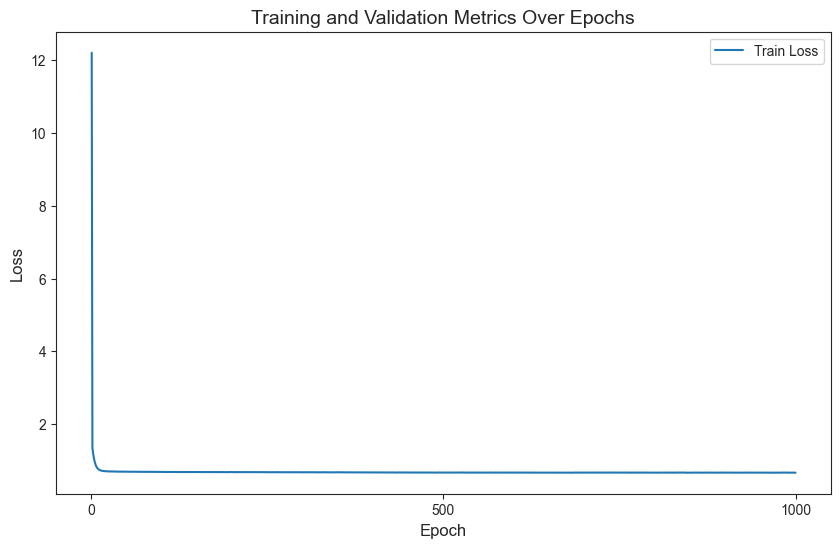

In [23]:
# Load metrics

metrics = pd.read_csv(log_file)
metrics = metrics.iloc[:-1]

metrics[['Epoch','Train_Loss', 'Valid_RMSE', 'Valid_MAE', 'Valid_R2']] = metrics[['Epoch', 'Train_Loss', 'Valid_RMSE', 'Valid_MAE', 'Valid_R2']].astype(float)

# Plot the training loss over epochs using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=metrics, x='Epoch', y='Train_Loss', label='Train Loss')
# sns.lineplot(data=metrics, x='Epoch', y='Valid_RMSE', label='Valid_RMSE')
# sns.lineplot(data=metrics, x='Epoch', y='Valid_MAE', label='Valid_MAE')
# Add titles and labels
plt.title('Training and Validation Metrics Over Epochs', fontsize=14)
# Define the range of tick positions
plt.xticks(ticks=np.arange(0, epochs+1, 500))  # Adjust step size as needed
plt.xlim(-50, epochs+50)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(False)
# Show the plot
plt.show()

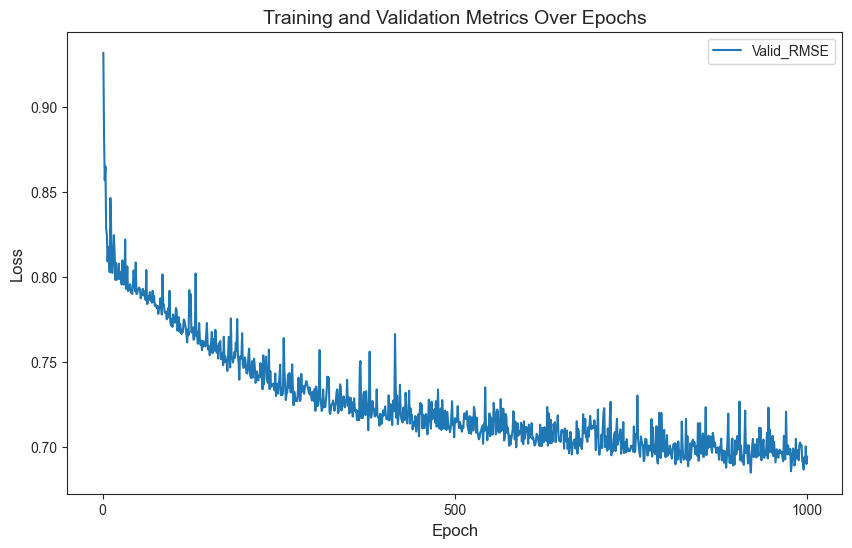

In [42]:
# Load metrics

metrics = pd.read_csv(log_file)
metrics = metrics.iloc[:-1]

metrics[['Epoch','Train_Loss', 'Valid_RMSE', 'Valid_MAE', 'Valid_R2']] = metrics[['Epoch', 'Train_Loss', 'Valid_RMSE', 'Valid_MAE', 'Valid_R2']].astype(float)

# Plot the training loss over epochs using seaborn
plt.figure(figsize=(10, 6))
# sns.lineplot(data=metrics, x='Epoch', y='Train_Loss', label='Train Loss')
sns.lineplot(data=metrics, x='Epoch', y='Valid_RMSE', label='Valid_RMSE')
# sns.lineplot(data=metrics, x='Epoch', y='Valid_MAE', label='Valid_MAE')
# Add titles and labels
plt.title('Training and Validation Metrics Over Epochs', fontsize=14)
# Define the range of tick positions
plt.xticks(ticks=np.arange(0, epochs+1, 500))  # Adjust step size as needed
plt.xlim(-50, epochs+50)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(False)
# Show the plot
plt.show()

